# Partial alignment of Spateo for 2D slices

In this tutorials, we will learn

In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Running this notebook on: ", device)

import spateo as st
print("Last run with spateo version:", st.__version__)

# Other imports
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
import numpy as np

# Uncomment the following if running on the server
import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

Running this notebook on:  cuda


2024-08-14 22:16:52.858430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 22:16:53.020238: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-14 22:16:53.020265: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-08-14 22:16:53.695175: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

Last run with spateo version: 1.0.2.dev519+46c6d93.dirty


(EE) 
Fatal server error:
(EE) Server is already active for display 99
	If this server is no longer running, remove /tmp/.X99-lock
	and start again.
(EE) 


# Load the data

The data used in this tutorial can be downloaded using the following links:

Mouse embryo E95 slice #32: https://drive.google.com/file/d/16gh_vApgzlvrplzbxYe-eODjZhvdNM4Z/view?usp=drive_link

Mouse embryo E95 slice #33: https://drive.google.com/file/d/16gh_vApgzlvrplzbxYe-eODjZhvdNM4Z/view?usp=drive_link

Adult mouse central nervous system from STARMap Plus dataset sagittal #3: https://drive.google.com/file/d/1kaeBK1xEc-AuKNUPgBaYTKc7si_7WASW/view?usp=drive_link

In [3]:
# Load the STARMap Plus slice
adata = st.read('./data/sagittal3.h5ad')

adata

AnnData object with n_obs × n_vars = 207591 × 1022
    obs: 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type'
    uns: 'Main_molecular_tissue_region_palette'
    obsm: 'spatial', 'spatial_raw'

# Cut pesudo slices

In [4]:
import sys
sys.path.insert(0, "/home/ylu/project")
from utils import *

# slices = st.align.split_slice(adata=adata,spatial_key='spatial_raw',split_num=4,axis=2,)
slices = split_slice(adata=adata,spatial_key='spatial_raw',split_num=4,axis=2,)

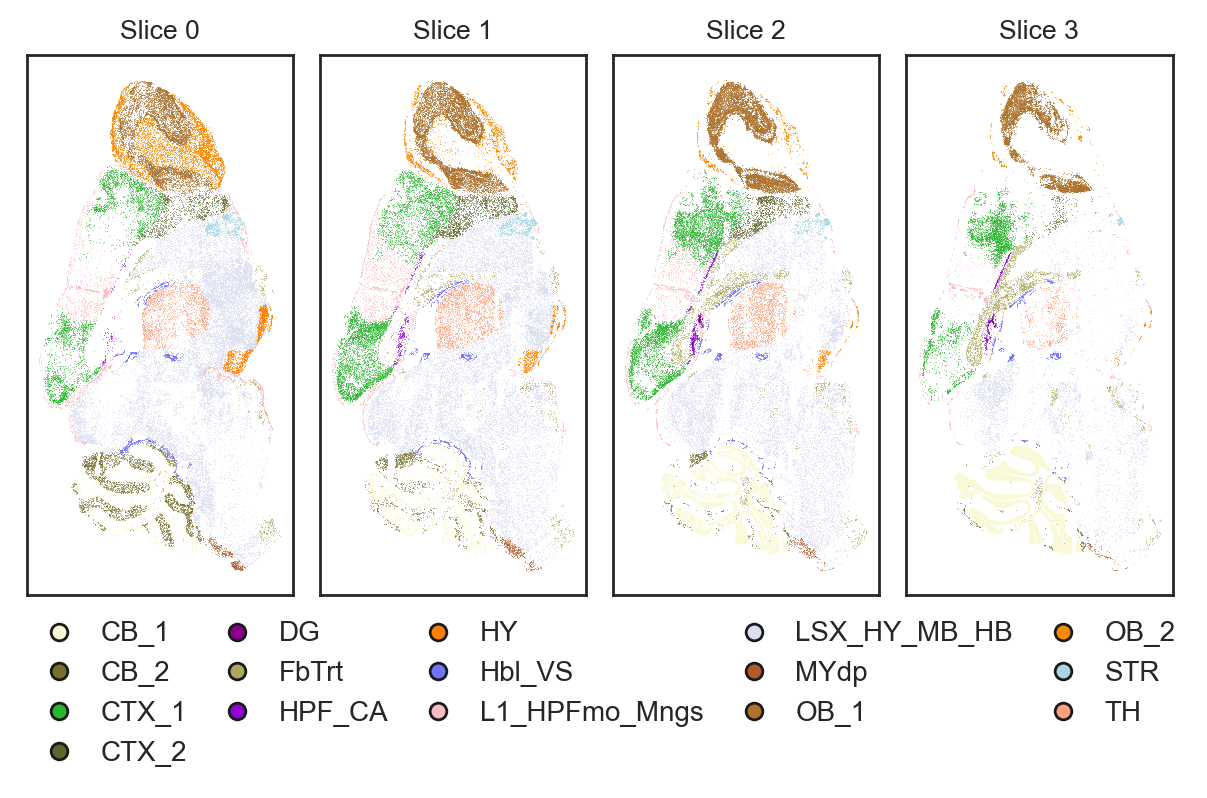

In [7]:
spatial_key = 'spatial_raw'
cluster_key = 'Main_molecular_tissue_region'
palette = adata.uns['Main_molecular_tissue_region_palette']
st.pl.slices_2d(
    slices = slices,
    label_key = cluster_key,
    spatial_key = spatial_key,
    height=4,
    center_coordinate=False,
    show_legend=True,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.49, 0) ,'ncol': 5, 'borderaxespad': -4, 'frameon': False},
    palette=palette,
)

In [25]:
slice1 = slices[0].copy()
slice2 = slices[1].copy()

slice1, slice2 = crop_slices(
    slice1, 
    slice2, 
    spatial_key='spatial', 
    overlay_ratio = 0.7,
)

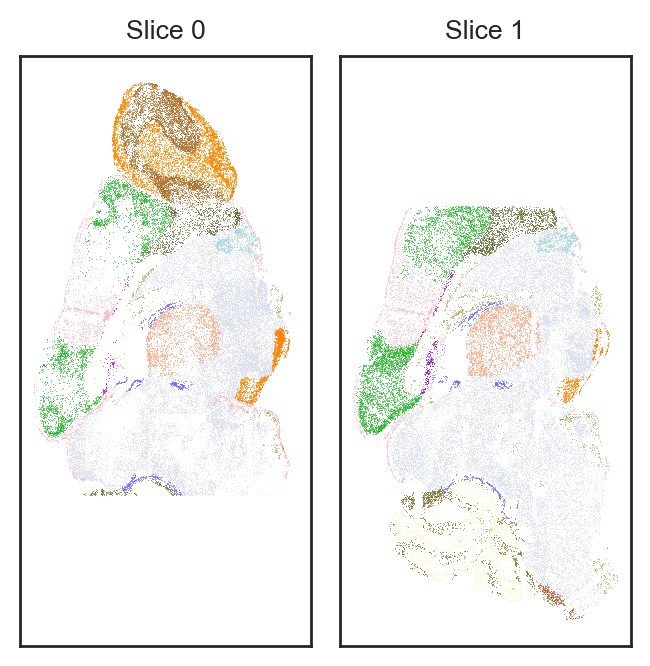

In [26]:
spatial_key = 'spatial'
cluster_key = 'Main_molecular_tissue_region'

st.pl.slices_2d(
    slices = [slice1, slice2],
    label_key = cluster_key,
    spatial_key = spatial_key,
    height=4,
    center_coordinate=False,
    show_legend=False,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.49, 0) ,'ncol': 5, 'borderaxespad': -4, 'frameon': False},
    palette=palette,
)

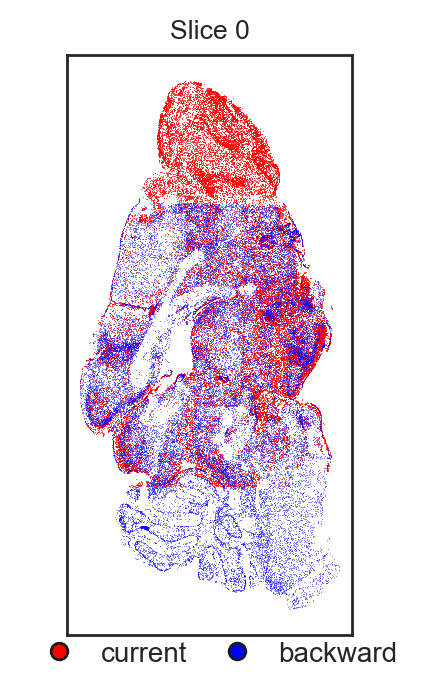

In [27]:
st.pl.overlay_slices_2d(slices = [slice1, slice2], spatial_key = 'spatial', height=4, overlay_type='backward')

In [33]:
rigid_transformation(
    slice2, 
    'spatial', 
    'spatial', 
    inplace=True
)

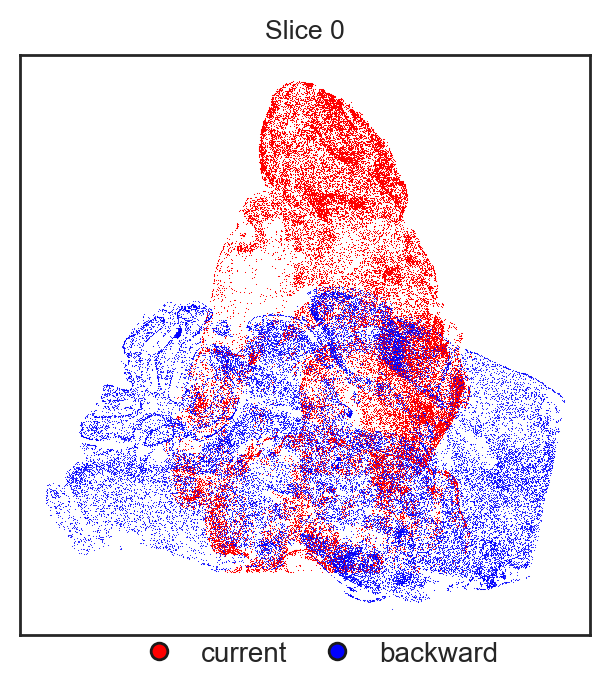

In [35]:
st.pl.overlay_slices_2d(slices = [slice1, slice2], spatial_key = 'spatial', height=4, overlay_type='backward')

# Spateo alignment

In [34]:
adata_pca = ad.concat([slice1,slice2], label='batch')
sc.tl.pca(adata_pca)
slice1.obsm['X_pca'] = adata_pca[adata_pca.obs['batch'] == '0'].obsm['X_pca'].copy()
slice2.obsm['X_pca'] = adata_pca[adata_pca.obs['batch'] == '1'].obsm['X_pca'].copy()

In [36]:
key_added = 'align_spatial'
spatial_key = 'spatial'
# spateo return aligned slices as well as the mapping matrix
aligned_slices, pis = st.align.morpho_align(
    models=[slice1, slice2],
    spatial_key=spatial_key,
    key_added=key_added,
    device=device,
    lambdaVF=1e3,
    beta=1e-3,
    partial_robust_level=50,
    rep_layer=['X_pca'],
    rep_field=['obsm'],
    dissimilarity=['cos'],
)

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([18108.9258, 18108.9258])...
|-----------> Scale: tensor([[20530.0488, 32617.4902],
        [22320.6562, 47592.1680]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [11.5115s]
|-----> Key Parameters: gamma: 0.6598348021507263; sigma2: 0.0010000000474974513; probability_parameters: [tensor(0.0100, device='cuda:0')]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [0.5604s]


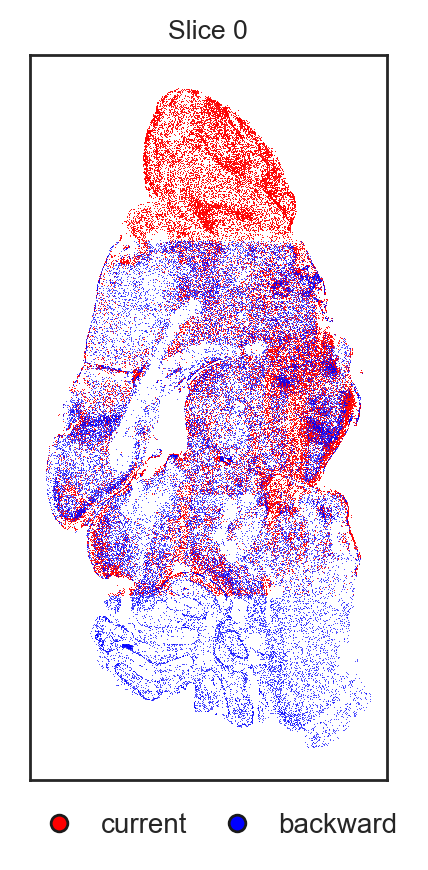

In [37]:
# Visualize the alignment results
st.pl.overlay_slices_2d(slices = aligned_slices, spatial_key = key_added, height=5, overlay_type='backward')